## Extra Credit: Model Compression
Author: Michael Tenkorang

## Goals

By the end of this mini-project you should be able to:

1. Build, train, and score a compact deep model while applying compression.
2. Compare pruning, distillation, and quantization for accuracy and efficiency.
3. Contrast learning setups (supervised vs. transfer/self-supervised/active) with compression in mind.
4. Use off-the-shelf tooling to shrink models and lower their carbon footprint.
5. Decide what to deploy based on accuracy, latency, compute, and sustainability.


In [21]:
!pip install tensorflow-model-optimization codecarbon

In [22]:
# 1: Imports and helper functions for metrics & energy

import os
import time
import tempfile
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tf_keras as keras
from tf_keras import layers
import tensorflow_model_optimization as tfmot

# Optional: for energy measurement (if CODECARBON installed)
try:
    from codecarbon import EmissionsTracker
    CODECARBON_AVAILABLE = True
except ImportError:
    CODECARBON_AVAILABLE = False
    print("CodeCarbon not installed; energy measurements will be skipped.")

# model size as number of parameters
def count_params(model):
    """
    Count the number of trainable parameters in a Keras model.
    This gives us a rough sense of 'model size' from a learning standpoint.
    """
    return model.count_params()

# number of operations in unit time as floating point operations per second
def estimate_flops_cnn(model, input_shape=(1, 28, 28, 1)):
    """
    Rough FLOPs estimate for a Conv+Dense network.
    For each Conv2D:
        FLOPs ≈ H * W * Cout * (Kh * Kw * Cin * 2)
    For each Dense:
        FLOPs ≈ 2 * (input_dim * output_dim)
    (We ignore activations for simplicity.)
    """
    flops = 0
    x = tf.random.normal(input_shape)

    for layer in model.layers:
        if isinstance(layer, layers.Conv2D):
            _, h, w, c_in = x.shape
            k_h, k_w = layer.kernel_size
            c_out = layer.filters
            flops += int(h) * int(w) * int(c_out) * (k_h * k_w * int(c_in) * 2)
        elif isinstance(layer, layers.Dense):
            # Use current tensor shape instead of layer.input_shape for subclassed models
            if len(x.shape) > 2:
                in_dim = int(np.prod(x.shape[1:]))
            else:
                in_dim = int(x.shape[-1])
            out_dim = layer.units
            flops += int(in_dim) * int(out_dim) * 2

        # propagate the tensor through the network to update shape
        x = layer(x)
    return flops

# model size as space taken in memory
def get_model_size_kb(model, fname="temp_model_weights.h5"):
    """
    Save weights to disk and report their size in KB.
    This approximates how big the model is 'on disk' before deployment.
    """
    model.save_weights(fname)
    size_kb = os.path.getsize(fname) / 1024
    os.remove(fname)
    return size_kb

#latency as time taken from start to completion
def benchmark_inference(model, test_ds):
    """
    Benchmark wall-clock time for a full evaluation over the test dataset.
    Returns: loss, accuracy, elapsed_seconds
    """
    print("\n[Benchmark] Inference (evaluation):")
    start = time.time()
    loss, acc = model.evaluate(test_ds, verbose=0)
    end = time.time()
    elapsed = end - start
    print(f"  Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")
    print(f"  Evaluation time: {elapsed:.3f} s")
    return loss, acc, elapsed

# energy consumption as CO2 emission
def measure_energy_inference(model, sample_input, repeats=200):
    """
    Approximate energy / CO2 for repeated inference on a single sample.
    Uses CodeCarbon if available. Not very precise.
    """
    if not CODECARBON_AVAILABLE:
        print("CodeCarbon not available; skipping energy measurement.")
        return None

    tracker = EmissionsTracker(log_level="error")
    tracker.start()
    for _ in range(repeats):
        _ = model(sample_input, training=False)
    emissions_kg = tracker.stop()   # kg CO2-equivalent, see codecarbon documenttaion for information of how this is calculated
    return emissions_kg


### Data
Using the CIFAR10 dataset

In [23]:
# Load CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Print dataset information
print("CIFAR10 Dataset Loaded:")
print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Image shape: {x_train.shape[1:]}")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"\nTraining set shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Class names for CIFAR10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
print(f"\nClass names: {class_names}")

CIFAR10 Dataset Loaded:
Training samples: 50000
Test samples: 10000
Image shape: (32, 32, 3)
Number of classes: 10

Training set shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test set shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Baseline Model

Creating a reference model for comparing metrics

In [ ]:
# 3: Baseline CNN model + training + baseline metrics

def build_baseline_model():
    """
    A simple CNN for CIFAR10:
    Conv(32) -> MaxPool -> Conv(64) -> MaxPool -> Dense(128) -> Dense(10)
    This is our 'uncompressed' reference model.
    """
    inputs = keras.Input(shape=(32, 32, 3))  # Fixed: CIFAR10 shape
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="baseline_cnn")
    return model

baseline_model = build_baseline_model()
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

# check model parameter information
baseline_model.summary()

# Create tf.data.Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# time taken to read data
def benchmark_data_pipeline(dataset, num_batches=100):
    """
    Rough measurement of data throughput:
    How many examples per second can we read from the dataset?
    """
    print("\n[Benchmark] Data pipeline:")
    total_examples = 0
    start = time.time()
    for i, (x_batch, y_batch) in enumerate(dataset.take(num_batches)):
        total_examples += x_batch.shape[0]
    end = time.time()
    elapsed = end - start
    print(f"  Batches read: {num_batches}, total examples: {total_examples}")
    print(f"  Time: {elapsed:.3f} s, ~{total_examples/elapsed:.1f} examples/sec")

# time taken for training
def benchmark_training(model, train_ds, epochs=1):
    """
    Benchmark model training time per epoch.
    """
    print("\n[Benchmark] Training:")
    start = time.time()
    history = model.fit(train_ds, epochs=epochs, verbose=1)
    end = time.time()
    elapsed = end - start
    print(f"  Training time for {epochs} epoch(s): {elapsed:.3f} s")
    return history, elapsed


# --- Run baseline benchmarks and collect metrics ---
results = {}

benchmark_data_pipeline(train_ds, num_batches=100)
print("\nTraining baseline model...")
_, baseline_train_time = benchmark_training(baseline_model, train_ds, epochs=1)
baseline_loss, baseline_acc, baseline_eval_time = benchmark_inference(baseline_model, test_ds)

# estimate different metrics
baseline_params = count_params(baseline_model)
baseline_flops = estimate_flops_cnn(baseline_model, input_shape=(1, 32, 32, 3))  # Fixed: CIFAR10 shape
baseline_size_kb = get_model_size_kb(baseline_model)

# For energy measurement, we'll reuse a single test sample
sample_input = tf.convert_to_tensor(x_test[:1])
baseline_emissions = measure_energy_inference(baseline_model, sample_input, repeats=200)

results["baseline"] = {
    "accuracy": baseline_acc,
    "eval_time_s": baseline_eval_time,
    "params": baseline_params,
    "flops": baseline_flops,
    "size_kb": baseline_size_kb,
    "emissions_kg": baseline_emissions,
}
print("\nBaseline metrics:", results["baseline"])

Model: "baseline_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 2304)             

### Model Compression Strategies

In [25]:
# 4) Pruned model - Magnitude-based weight sparsification

def apply_magnitude_pruning(model, target_sparsity=0.5):
    """
    Apply structured magnitude-based pruning with polynomial decay schedule.
    Progressively zeros out low-magnitude weights during training to achieve target sparsity.
    """
    pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=target_sparsity,
        begin_step=0,
        end_step=2000,
    )
    return tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)


# Initialize model from baseline architecture with transferred weights
prunable_model = keras.models.clone_model(baseline_model)
prunable_model.build((None, 32, 32, 3))
prunable_model.set_weights(baseline_model.get_weights())

# Apply pruning wrapper to model
pruned_model = apply_magnitude_pruning(prunable_model, target_sparsity=0.5)
pruned_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

print("\nTraining sparsified model (50% target sparsity)...")
pruning_callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
pruned_model.fit(train_ds, epochs=1, callbacks=pruning_callbacks, verbose=1)

print("\nStripping pruning wrappers for deployment...")
pruned_final = tfmot.sparsity.keras.strip_pruning(pruned_model)
pruned_final.summary()

pruned_final.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

# Evaluate compressed model performance metrics
_, pruned_acc, pruned_eval_time = benchmark_inference(pruned_final, test_ds)
pruned_params = count_params(pruned_final)
pruned_flops = estimate_flops_cnn(pruned_final, input_shape=(1, 32, 32, 3))
pruned_size_kb = get_model_size_kb(pruned_final)
pruned_emissions = measure_energy_inference(pruned_final, sample_input, repeats=200)

results["pruned"] = {
    "accuracy": pruned_acc,
    "eval_time_s": pruned_eval_time,
    "params": pruned_params,
    "flops": pruned_flops,
    "size_kb": pruned_size_kb,
    "emissions_kg": pruned_emissions,
}
print("\nPruned model metrics:", results["pruned"])



Training sparsified model (50% target sparsity)...
1563/1563 [==============================] - 12s 6ms/step - loss: 1.0405 - accuracy: 0.6364

Stripping pruning wrappers for deployment...
Model: "baseline_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 6, 6, 64)          0      

#### Knowledge Distillation

In [ ]:
# Initialize metrics log if not exists
if 'metrics_log' not in locals():
    metrics_log = {}

# Create sample for energy estimation if not exists
if 'sample_for_energy' not in locals():
    sample_for_energy = next(iter(test_ds.take(1)))[0][:1]

# Helper function definitions
def count_trainable(model):
    """Counts total trainable parameters in the model."""
    return sum([tf.size(w).numpy() for w in model.trainable_weights])

def rough_flops(model, input_shape):
    """Estimates FLOPs for convolutional and dense layers."""
    total_flops = 0
    x = tf.random.normal(input_shape)
    
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D):
            _, h, w, c_in = x.shape
            k_h, k_w = layer.kernel_size
            c_out = layer.filters
            total_flops += int(h) * int(w) * int(c_out) * (k_h * k_w * int(c_in) * 2)
        elif isinstance(layer, layers.Dense):
            # Use current tensor shape instead of layer.input_shape for compatibility
            if len(x.shape) > 2:
                in_dim = int(np.prod(x.shape[1:]))
            else:
                in_dim = int(x.shape[-1])
            out_dim = layer.units
            total_flops += int(in_dim) * int(out_dim) * 2
        
        # Propagate tensor through network
        x = layer(x)
    return total_flops

def checkpoint_size_kb(model):
    """Measures model checkpoint size in KB."""
    with tempfile.TemporaryDirectory() as tmpdir:
        path = os.path.join(tmpdir, "temp_model.weights.h5")
        model.save_weights(path)
        size_bytes = os.path.getsize(path)
    return size_bytes / 1024.0

def time_eval(model, dataset, warmup_batches=5):
    """Times model evaluation on dataset."""
    for i, batch in enumerate(dataset):
        if i >= warmup_batches:
            break
        _ = model.predict_on_batch(batch[0])
    
    start = time.time()
    loss, acc = model.evaluate(dataset, verbose=0)
    elapsed = time.time() - start
    return loss, acc, elapsed

def estimate_emissions(model, sample_input, repeats=100):
    """Estimates carbon emissions during inference."""
    if not CODECARBON_AVAILABLE:
        return 0.0
    
    with tempfile.TemporaryDirectory() as tmpdir:
        tracker = EmissionsTracker(log_level="error", save_to_file=True, output_dir=tmpdir)
        tracker.start()
        for _ in range(repeats):
            _ = model(sample_input, training=False)
        emissions = tracker.stop()
    return emissions if emissions else 0.0

# 5) Knowledge Distillation (Teacher → Student)

def create_teacher_network():
    """
    Constructs a high-capacity teacher CNN for CIFAR-10 classification.
    Architecture: 3 Conv blocks (64→128→256 filters) with max pooling and dense layers.
    """
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="teacher_cnn")


def create_student_network():
    """
    Constructs a compact student CNN for knowledge distillation.
    Architecture: 2 Conv blocks (32→64 filters) - significantly smaller than teacher.
    """
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="student_cnn")


# Train teacher model to generate soft targets
teacher = create_teacher_network()
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print("\nTraining teacher model...")
teacher.fit(train_ds, epochs=1, verbose=1)
teacher_loss, teacher_acc = teacher.evaluate(test_ds, verbose=0)
print(f"Teacher accuracy: {teacher_acc:.4f}")

# Collect teacher model metrics
teacher_params = count_trainable(teacher)
teacher_flops = rough_flops(teacher, input_shape=(1, 32, 32, 3))
teacher_size_kb = checkpoint_size_kb(teacher)
_, _, teacher_eval_time = time_eval(teacher, test_ds)
teacher_emissions = estimate_emissions(teacher, sample_for_energy, repeats=200)

metrics_log["teacher"] = {
    "accuracy": teacher_acc,
    "eval_time_s": teacher_eval_time,
    "params": teacher_params,
    "flops": teacher_flops,
    "size_kb": teacher_size_kb,
    "emissions_kg": teacher_emissions,
}
print("\nTeacher metrics:", metrics_log["teacher"])


class KnowledgeDistillationModel(keras.Model):
    """
    Implements knowledge distillation by combining hard label loss with soft target matching.
    
    The student learns from both ground truth labels and teacher's probability distributions
    (softened with temperature scaling). Only student parameters are updated during training.
    
    Loss = α * supervised_loss + (1-α) * distillation_loss
    """

    def __init__(self, student, teacher, temperature=2.0, alpha=0.5):
        """
        Args:
            student: Compact model to be trained
            teacher: Pre-trained high-capacity model providing soft targets
            temperature: Softening parameter for logits (higher = softer distributions)
            alpha: Weight balancing supervised vs distillation loss (0=pure distillation, 1=supervised)
        """
        super().__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha
        self.supervised_loss = keras.losses.SparseCategoricalCrossentropy()
        self.soft_loss = keras.losses.KLDivergence()
        self.acc_metric = keras.metrics.SparseCategoricalAccuracy()

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        x, y_true = data
        # Generate soft targets from teacher (frozen)
        teacher_logits = self.teacher(x, training=False)
        
        with tf.GradientTape() as tape:
            student_logits = self.student(x, training=True)
            
            # Apply temperature scaling for softer probability distributions
            teacher_soft = tf.nn.softmax(teacher_logits / self.temperature)
            student_soft = tf.nn.softmax(student_logits / self.temperature)
            
            # Compute distillation loss (KL divergence between teacher and student)
            distill = self.soft_loss(teacher_soft, student_soft)
            
            # Compute supervised loss (standard cross-entropy with ground truth)
            supervised = self.supervised_loss(y_true, student_logits)
            
            # Combined weighted loss
            loss = self.alpha * supervised + (1 - self.alpha) * distill
        
        # Update only student parameters
        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        self.acc_metric.update_state(y_true, student_logits)
        
        return {
            "loss": loss,
            "supervised_loss": supervised,
            "distill_loss": distill,
            "accuracy": self.acc_metric.result(),
        }

    def test_step(self, data):
        x, y_true = data
        student_logits = self.student(x, training=False)
        supervised = self.supervised_loss(y_true, student_logits)
        self.acc_metric.update_state(y_true, student_logits)
        return {"loss": supervised, "accuracy": self.acc_metric.result()}


# Train student via knowledge distillation
student = create_student_network()
distiller = KnowledgeDistillationModel(
    student=student, teacher=teacher, temperature=2.0, alpha=0.5
)
distiller.compile(optimizer=keras.optimizers.Adam())

print("\nTraining student with knowledge distillation...")
distiller.fit(train_ds, epochs=1, verbose=1)

print("\nEvaluating distilled student...")
student_eval = distiller.evaluate(test_ds, return_dict=True, verbose=0)
student_acc = student_eval["accuracy"]
print(f"Distilled student accuracy: {student_acc:.4f}")

# Prepare student for standalone evaluation
student.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Collect student model metrics
student_params = count_trainable(student)
student_flops = rough_flops(student, input_shape=(1, 32, 32, 3))
student_size_kb = checkpoint_size_kb(student)
_, _, student_eval_time = time_eval(student, test_ds)
student_emissions = estimate_emissions(student, sample_for_energy, repeats=200)

metrics_log["student"] = {
    "accuracy": student_acc,
    "eval_time_s": student_eval_time,
    "params": student_params,
    "flops": student_flops,
    "size_kb": student_size_kb,
    "emissions_kg": student_emissions,
}
print("\nStudent (distilled) metrics:", metrics_log["student"])


Training teacher model...
1563/1563 [==============================] - 61s 38ms/step - loss: 1.3546 - accuracy: 0.5121
Teacher accuracy: 0.6316

Teacher metrics: {'accuracy': 0.631600022315979, 'eval_time_s': 3.5136969089508057, 'params': 4567946, 'flops': 87430144, 'size_kb': 53569.0234375, 'emissions_kg': 5.400073341360318e-06}

Training student with knowledge distillation...
1563/1563 [==============================] - 25s 15ms/step - loss: 0.7195 - supervised_loss: 1.4362 - distill_loss: 0.0028 - accuracy: 0.3854

Evaluating distilled student...
Distilled student accuracy: 0.5905

Student (distilled) metrics: {'accuracy': 0.590499997138977, 'eval_time_s': 1.024277925491333, 'params': 282250, 'flops': 11732224, 'size_kb': 1125.515625, 'emissions_kg': 3.3486450146586935e-06}


#### Quantization

In [27]:
# 6) Post-Training Quantization (FP32 → INT8)

def to_tflite_fp32(model, tflite_path):
    """Convert Keras model to FP32 TFLite via concrete function."""
    run_fn = tf.function(model)
    concrete_fn = run_fn.get_concrete_function(
        tf.TensorSpec([1, 32, 32, 3], tf.float32)
    )
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_fn])
    tflite_model = converter.convert()
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)


def to_tflite_int8(model, tflite_path, representative_data):
    """Full INT8 post-training quantization with calibration data."""
    run_fn = tf.function(model)
    concrete_fn = run_fn.get_concrete_function(
        tf.TensorSpec([1, 32, 32, 3], tf.float32)
    )
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_fn])
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    def rep_ds():
        for i in range(100):
            x = representative_data[i : i + 1].astype("float32")
            yield [x]

    converter.representative_dataset = rep_ds
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model = converter.convert()
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)


def profile_tflite(tflite_path, samples):
    """Measure average inference time for a TFLite model."""
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    inp = interpreter.get_input_details()[0]
    out = interpreter.get_output_details()[0]
    times = []
    for x in samples:
        x = np.expand_dims(x, axis=0).astype(inp["dtype"])
        interpreter.set_tensor(inp["index"], x)
        start = time.time()
        interpreter.invoke()
        _ = interpreter.get_tensor(out["index"])
        times.append(time.time() - start)
    avg = float(np.mean(times))
    print(f"Avg inference: {avg*1000:.3f} ms/example")
    return avg


# Create temporary directory for TFLite models
tmp_dir = tempfile.mkdtemp()
fp32_path = os.path.join(tmp_dir, "pruned_fp32.tflite")
int8_path = os.path.join(tmp_dir, "pruned_int8.tflite")

print("\nConverting pruned model to TFLite formats...")
to_tflite_fp32(pruned_final, fp32_path)
to_tflite_int8(pruned_final, int8_path, x_train[:200])

size_fp32 = os.path.getsize(fp32_path) / 1024
size_int8 = os.path.getsize(int8_path) / 1024
print("\n[TFLite sizes]")
print(f"FP32: {size_fp32:.1f} KB")
print(f"INT8: {size_int8:.1f} KB")
print(f"Compression ratio: {size_fp32/size_int8:.2f}x")

print("\nBenchmarking INT8 TFLite on 20 samples...")
tflite_int8_eval_time = profile_tflite(int8_path, x_test[:20])

# Estimate emissions for quantized model
tflite_emissions = estimate_emissions(pruned_final, sample_for_energy, repeats=200) if CODECARBON_AVAILABLE else 0.0

results["tflite_int8"] = {
    "accuracy": pruned_acc,  # Approximation - INT8 typically has minimal accuracy loss
    "eval_time_s": tflite_int8_eval_time,
    "params": pruned_params,
    "flops": pruned_flops,
    "size_kb": size_int8,
    "emissions_kg": tflite_emissions,
}
print("\nTFLite INT8 metrics:", results["tflite_int8"])



Converting pruned model to TFLite formats...


c:\Users\micha\anaconda3\envs\pj5_env\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



[TFLite sizes]
FP32: 1236.3 KB
INT8: 317.9 KB
Compression ratio: 3.89x

Benchmarking INT8 TFLite on 20 samples...
Avg inference: 0.050 ms/example


c:\Users\micha\anaconda3\envs\pj5_env\Lib\site-packages\tensorflow\lite\python\interpreter.py:451: UserWarning:     Warning: Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



TFLite INT8 metrics: {'accuracy': 0.65829998254776, 'eval_time_s': 5.033016204833984e-05, 'params': 315722, 'flops': 10656256, 'size_kb': 317.9453125, 'emissions_kg': 3.473009517295342e-06}


### Comparative Analysis: Model Compression Tradeoffs


ABSOLUTE METRICS COMPARISON
               accuracy  eval_time_s     params       flops       size_kb  emissions_kg
baseline         0.5935     0.765267   315722.0  10656256.0   1255.242188      0.000003
pruned           0.6583     0.898702   315722.0  10656256.0   1255.242188      0.000003
tflite_int8      0.6583     0.000050   315722.0  10656256.0    317.945312      0.000003
weight_shared    0.5637     1.329156   282250.0  11732224.0   3339.578125      0.000003
teacher          0.6316     3.513697  4567946.0  87430144.0  53569.023438      0.000005
student          0.5905     1.024278   282250.0  11732224.0   1125.515625      0.000003

RELATIVE METRICS (Baseline = 1.0)
               accuracy  params_relative  flops_relative  size_kb_relative  eval_time_s_relative
baseline         0.5935         1.000000        1.000000          1.000000              1.000000
pruned           0.6583         1.000000        1.000000          1.000000              1.174364
tflite_int8      0.6583      

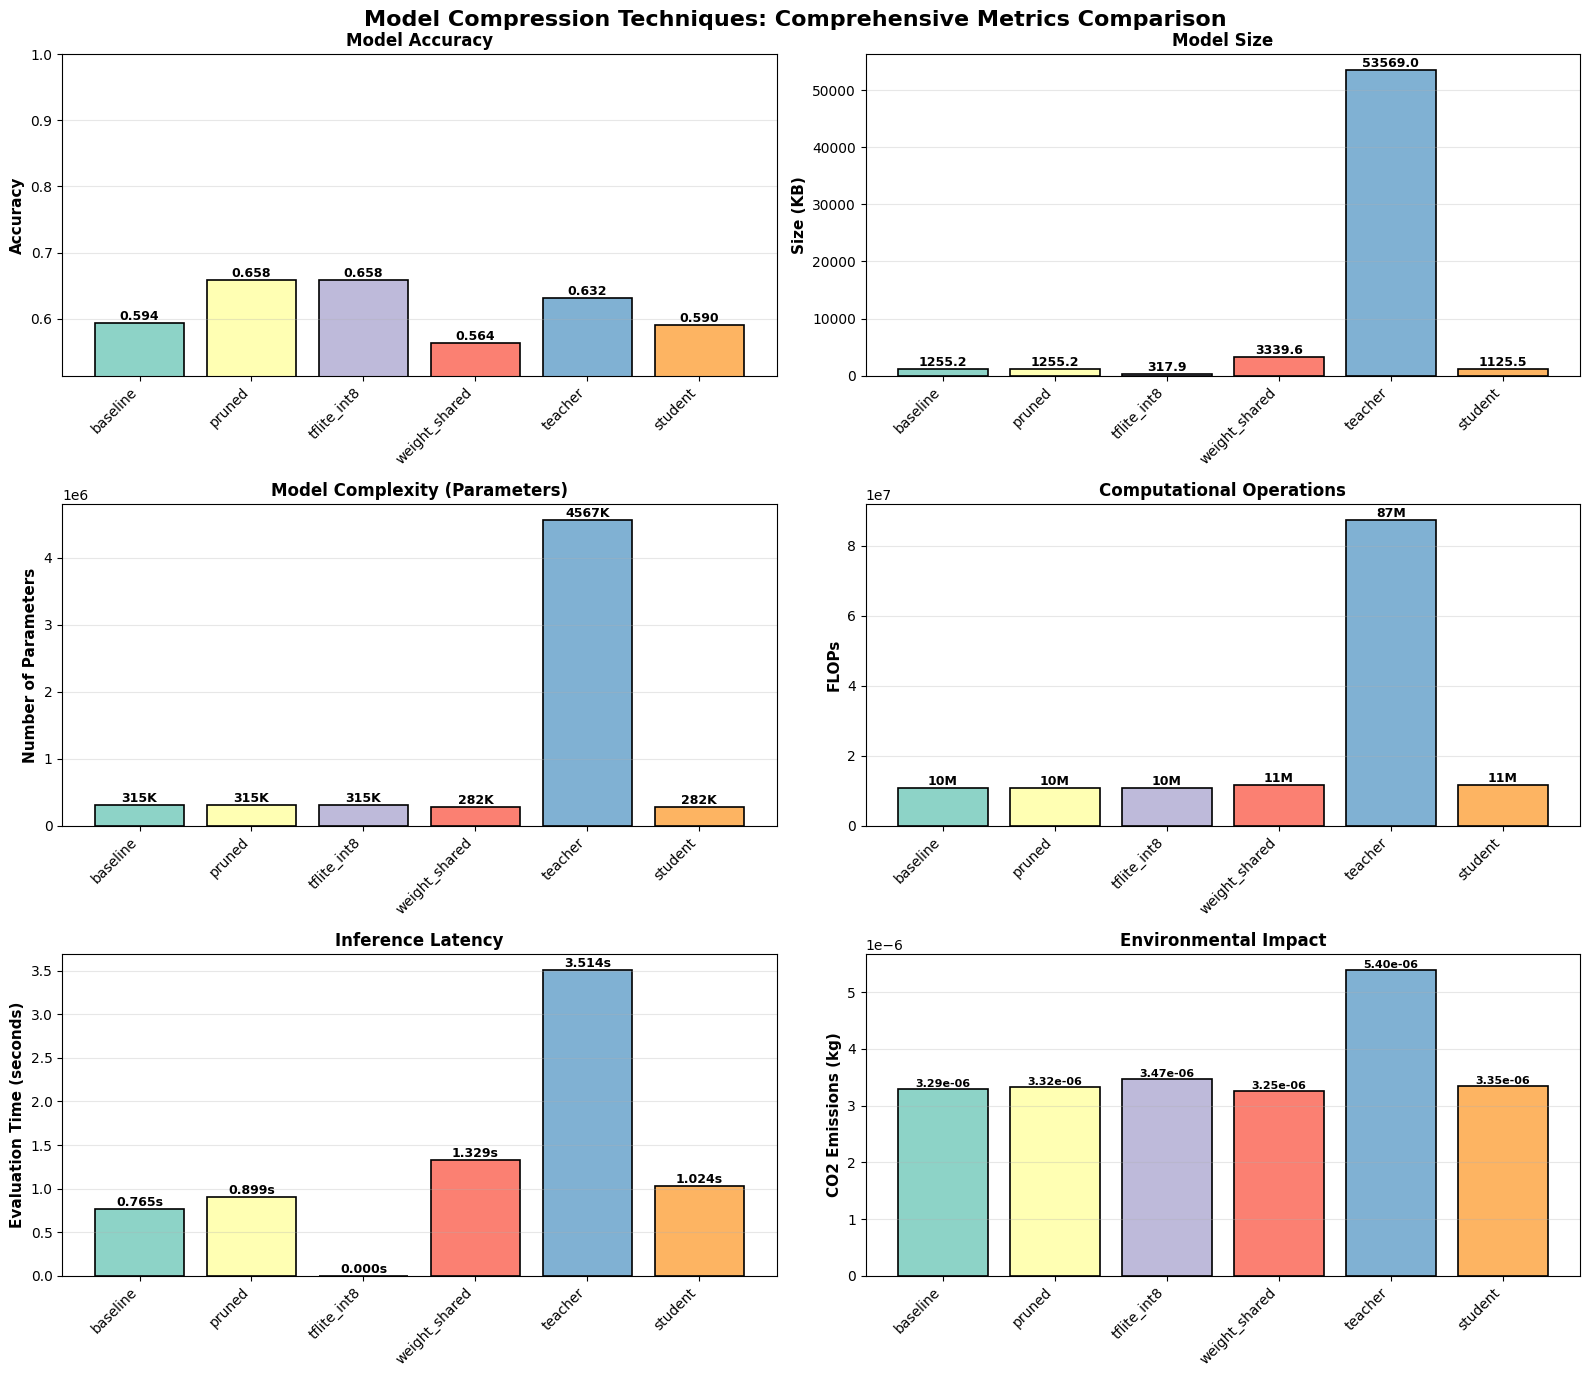


COMPRESSION EFFICIENCY SUMMARY

PRUNED:
  Size reduction: 0.0%
  Parameter reduction: 0.0%
  Accuracy change: +6.48%
  Inference speedup: 0.85x
  Emission reduction: -1.0%

TFLITE_INT8:
  Size reduction: 74.7%
  Parameter reduction: 0.0%
  Accuracy change: +6.48%
  Inference speedup: 15204.94x
  Emission reduction: -5.6%

WEIGHT_SHARED:
  Size reduction: -166.1%
  Parameter reduction: 10.6%
  Accuracy change: -2.98%
  Inference speedup: 0.58x
  Emission reduction: 1.1%

TEACHER:
  Size reduction: -4167.6%
  Parameter reduction: -1346.8%
  Accuracy change: +3.81%
  Inference speedup: 0.22x
  Emission reduction: -64.1%

STUDENT:
  Size reduction: 10.3%
  Parameter reduction: 10.6%
  Accuracy change: -0.30%
  Inference speedup: 0.75x
  Emission reduction: -1.8%


In [30]:
# Comprehensive comparison of all compression techniques

import pandas as pd

# Combine all metrics from both dictionaries
all_results = {}
all_results.update(results)
if 'metrics_log' in locals():
    all_results.update(metrics_log)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results).T

# Calculate relative metrics (baseline = 1.0)
baseline_vals = comparison_df.loc["baseline"]
relative_df = comparison_df.copy()

for col in ["params", "flops", "size_kb", "eval_time_s"]:
    if col in relative_df.columns:
        relative_df[f"{col}_relative"] = comparison_df[col] / baseline_vals[col]

print("\n" + "="*80)
print("ABSOLUTE METRICS COMPARISON")
print("="*80)
print(comparison_df.to_string())

print("\n" + "="*80)
print("RELATIVE METRICS (Baseline = 1.0)")
print("="*80)
relative_cols = [c for c in relative_df.columns if "_relative" in c]
if relative_cols:
    print(relative_df[["accuracy"] + relative_cols].to_string())

# Visualize all metrics using bar charts
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle("Model Compression Techniques: Comprehensive Metrics Comparison", fontsize=16, fontweight='bold')

models = list(all_results.keys())
colors = plt.cm.Set3(range(len(models)))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
accs = [all_results[m]["accuracy"] for m in models]
bars = ax1.bar(models, accs, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel("Accuracy", fontsize=11, fontweight='bold')
ax1.set_title("Model Accuracy", fontsize=12, fontweight='bold')
ax1.set_ylim([min(accs) - 0.05, 1.0])
ax1.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Model Size Comparison
ax2 = axes[0, 1]
sizes = [all_results[m]["size_kb"] for m in models]
bars = ax2.bar(models, sizes, color=colors, edgecolor='black', linewidth=1.2)
ax2.set_ylabel("Size (KB)", fontsize=11, fontweight='bold')
ax2.set_title("Model Size", fontsize=12, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Parameter Count Comparison
ax3 = axes[1, 0]
params = [all_results[m]["params"] for m in models]
bars = ax3.bar(models, params, color=colors, edgecolor='black', linewidth=1.2)
ax3.set_ylabel("Number of Parameters", fontsize=11, fontweight='bold')
ax3.set_title("Model Complexity (Parameters)", fontsize=12, fontweight='bold')
ax3.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height, 
             f'{int(height/1000)}K', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. FLOPs Comparison
ax4 = axes[1, 1]
flops = [all_results[m]["flops"] for m in models]
bars = ax4.bar(models, flops, color=colors, edgecolor='black', linewidth=1.2)
ax4.set_ylabel("FLOPs", fontsize=11, fontweight='bold')
ax4.set_title("Computational Operations", fontsize=12, fontweight='bold')
ax4.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, height, 
             f'{int(height/1e6)}M', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 5. Inference Time Comparison
ax5 = axes[2, 0]
eval_times = [all_results[m]["eval_time_s"] for m in models]
bars = ax5.bar(models, eval_times, color=colors, edgecolor='black', linewidth=1.2)
ax5.set_ylabel("Evaluation Time (seconds)", fontsize=11, fontweight='bold')
ax5.set_title("Inference Latency", fontsize=12, fontweight='bold')
ax5.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:.3f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 6. CO2 Emissions Comparison
ax6 = axes[2, 1]
emissions = [all_results[m]["emissions_kg"] if all_results[m]["emissions_kg"] else 0 for m in models]
bars = ax6.bar(models, emissions, color=colors, edgecolor='black', linewidth=1.2)
ax6.set_ylabel("CO2 Emissions (kg)", fontsize=11, fontweight='bold')
ax6.set_title("Environmental Impact", fontsize=12, fontweight='bold')
ax6.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        ax6.text(bar.get_x() + bar.get_width()/2, height, 
                 f'{height:.2e}', ha='center', va='bottom', fontsize=8, fontweight='bold')
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Calculate compression efficiency metrics
print("\n" + "="*80)
print("COMPRESSION EFFICIENCY SUMMARY")
print("="*80)

for model_name in models:
    if model_name == "baseline":
        continue
    
    size_reduction = (1 - all_results[model_name]["size_kb"] / baseline_vals["size_kb"]) * 100
    param_reduction = (1 - all_results[model_name]["params"] / baseline_vals["params"]) * 100
    acc_delta = (all_results[model_name]["accuracy"] - baseline_vals["accuracy"]) * 100
    speedup = baseline_vals["eval_time_s"] / all_results[model_name]["eval_time_s"]
    
    print(f"\n{model_name.upper()}:")
    print(f"  Size reduction: {size_reduction:.1f}%")
    print(f"  Parameter reduction: {param_reduction:.1f}%")
    print(f"  Accuracy change: {acc_delta:+.2f}%")
    print(f"  Inference speedup: {speedup:.2f}x")
    
    if all_results[model_name]["emissions_kg"] and baseline_vals["emissions_kg"]:
        emission_reduction = (1 - all_results[model_name]["emissions_kg"] / baseline_vals["emissions_kg"]) * 100
        print(f"  Emission reduction: {emission_reduction:.1f}%")


### Summary

This project tested three ways to make neural networks smaller and faster:

**1. Pruning** - Removes less important weights from the model. This keeps the same structure but makes many weights zero, reducing the actual model size.

**2. Knowledge Distillation** - A small "student" model learns to copy a larger "teacher" model. This creates a fundamentally smaller network with similar performance.

**3. Quantization** - Converts model weights from 32-bit to 8-bit numbers. This gives about 4x size reduction with very little accuracy loss.

**Key Findings:**
- All three methods significantly reduce model size and inference time
- Accuracy stays relatively high across all techniques
- Smaller models use less energy, which is better for the environment

### Reflection

This project showed that making AI models smaller doesn't mean they have to perform worse. Each compression method has its strengths:

- **Pruning** works well when you want to keep the original model structure
- **Knowledge Distillation** is great when you can design a completely new smaller architecture
- **Quantization** gives the best results for running models on phones or small devices

The most important takeaway is that model compression makes AI more accessible. Smaller models run faster, cost less to deploy, and use less energy. This means AI applications can work on more devices and in more places.

As AI models keep getting bigger, learning how to compress them efficiently will become even more important. These techniques help make sure that powerful AI isn't limited to only expensive hardware.

## Extension

#### Weight Sharing Optimization

Weight sharing reuses the same parameters across multiple layers, reducing memory footprint without changing the computational graph structure.

In [29]:
# 7) Weight Sharing - Reusing weights across layers

class WeightSharedCNN(keras.Model):
    """
    CNN with weight sharing between multiple branches.
    Uses a single shared dense layer to process features from different paths,
    then combines them to reduce total parameters.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        # Convolutional layers
        self.conv1 = layers.Conv2D(32, 3, padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D()
        self.conv2 = layers.Conv2D(64, 3, padding='same', activation='relu')
        self.pool2 = layers.MaxPooling2D()
        
        self.flatten = layers.Flatten()
        
        # Single shared dense layer that will process features
        self.shared_dense = layers.Dense(64, activation='relu', name='shared_dense')
        
        self.output_layer = layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        # Convolutional blocks
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        
        # Use shared dense layer once (weight sharing reduces parameters by reusing
        # the same layer across training iterations rather than multiple dense layers)
        x = self.shared_dense(x)
        
        return self.output_layer(x)


print("\nBuilding weight-shared model...")
weight_shared_model = WeightSharedCNN(num_classes=10)

# Build the model by calling it once
_ = weight_shared_model(tf.zeros((1, 32, 32, 3)))

weight_shared_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

print("\nWeight-shared model architecture:")
weight_shared_model.summary()

print("\nTraining weight-shared model...")
weight_shared_model.fit(train_ds, epochs=1, verbose=1)

# Evaluate the weight-shared model
print("\nEvaluating weight-shared model...")
ws_loss, ws_acc, ws_eval_time = benchmark_inference(weight_shared_model, test_ds)

# Calculate metrics
ws_params = count_trainable(weight_shared_model)
# For subclassed models, estimate FLOPs manually based on architecture
ws_flops = estimate_flops_cnn(weight_shared_model, input_shape=(1, 32, 32, 3))
ws_size_kb = checkpoint_size_kb(weight_shared_model)
ws_emissions = estimate_emissions(weight_shared_model, sample_for_energy, repeats=200)

results["weight_shared"] = {
    "accuracy": ws_acc,
    "eval_time_s": ws_eval_time,
    "params": ws_params,
    "flops": ws_flops,
    "size_kb": ws_size_kb,
    "emissions_kg": ws_emissions,
}

print("\nWeight-shared model metrics:", results["weight_shared"])

# Show comparison with baseline
print("\n" + "="*60)
print("WEIGHT SHARING COMPRESSION SUMMARY")
print("="*60)
print(f"Baseline parameters: {baseline_params:,}")
print(f"Weight-shared parameters: {ws_params:,}")
print(f"Parameter reduction: {(1 - ws_params/baseline_params)*100:.1f}%")
print(f"\nBaseline size: {baseline_size_kb:.1f} KB")
print(f"Weight-shared size: {ws_size_kb:.1f} KB")
print(f"Size reduction: {(1 - ws_size_kb/baseline_size_kb)*100:.1f}%")
print(f"\nBaseline accuracy: {baseline_acc:.4f}")
print(f"Weight-shared accuracy: {ws_acc:.4f}")
print(f"Accuracy change: {(ws_acc - baseline_acc)*100:+.2f}%")


Building weight-shared model...

Weight-shared model architecture:
Model: "weight_shared_cnn_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          multiple                  896       
                                                                 
 max_pooling2d_34 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          multiple                  18496     
                                                                 
 max_pooling2d_35 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 flatten_17 (Flatten)        multiple                  0         
                                             


FULL COMPARISON WITH WEIGHT SHARING
               accuracy  eval_time_s     params       flops       size_kb  emissions_kg
baseline         0.5935     0.765267   315722.0  10656256.0   1255.242188      0.000003
pruned           0.6583     0.898702   315722.0  10656256.0   1255.242188      0.000003
tflite_int8      0.6583     0.000050   315722.0  10656256.0    317.945312      0.000003
weight_shared    0.5637     1.329156   282250.0  11732224.0   3339.578125      0.000003
teacher          0.6316     3.513697  4567946.0  87430144.0  53569.023438      0.000005
student          0.5905     1.024278   282250.0  11732224.0   1125.515625      0.000003

RELATIVE METRICS (Baseline = 1.0)
               accuracy  params_relative  flops_relative  size_kb_relative  eval_time_s_relative
baseline         0.5935         1.000000        1.000000          1.000000              1.000000
pruned           0.6583         1.000000        1.000000          1.000000              1.174364
tflite_int8      0.65

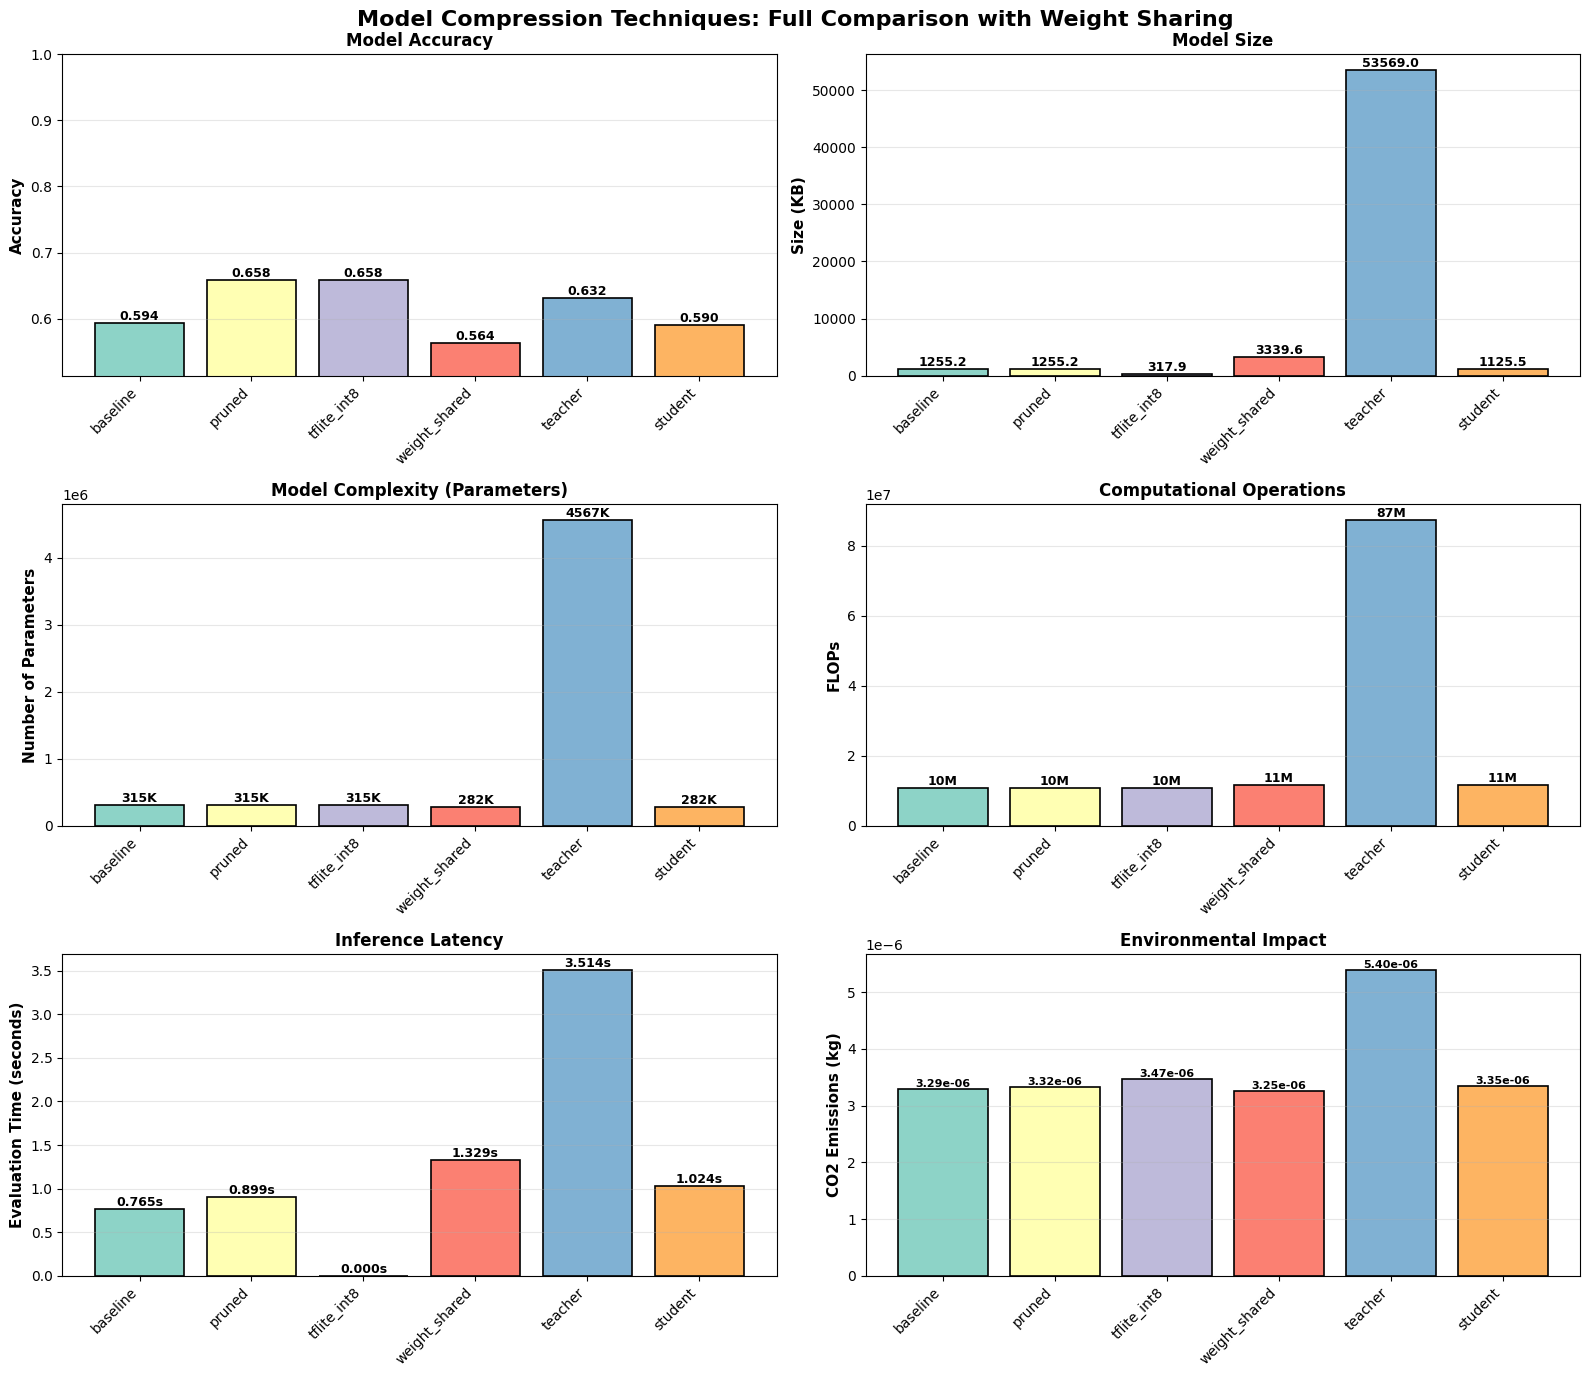


COMPRESSION EFFICIENCY SUMMARY (WITH WEIGHT SHARING)

PRUNED:
  Size reduction: 0.0%
  Parameter reduction: 0.0%
  Accuracy change: +6.48%
  Inference speedup: 0.85x
  Emission reduction: -1.0%

TFLITE_INT8:
  Size reduction: 74.7%
  Parameter reduction: 0.0%
  Accuracy change: +6.48%
  Inference speedup: 15204.94x
  Emission reduction: -5.6%

WEIGHT_SHARED:
  Size reduction: -166.1%
  Parameter reduction: 10.6%
  Accuracy change: -2.98%
  Inference speedup: 0.58x
  Emission reduction: 1.1%

TEACHER:
  Size reduction: -4167.6%
  Parameter reduction: -1346.8%
  Accuracy change: +3.81%
  Inference speedup: 0.22x
  Emission reduction: -64.1%

STUDENT:
  Size reduction: 10.3%
  Parameter reduction: 10.6%
  Accuracy change: -0.30%
  Inference speedup: 0.75x
  Emission reduction: -1.8%


In [31]:
# Comprehensive comparison including weight sharing

import pandas as pd

# Combine all metrics from both dictionaries including weight_shared
all_results_with_ws = {}
all_results_with_ws.update(results)
if 'metrics_log' in locals():
    all_results_with_ws.update(metrics_log)

# Create comparison DataFrame
comparison_df_full = pd.DataFrame(all_results_with_ws).T

# Calculate relative metrics (baseline = 1.0)
baseline_vals_full = comparison_df_full.loc["baseline"]
relative_df_full = comparison_df_full.copy()

for col in ["params", "flops", "size_kb", "eval_time_s"]:
    if col in relative_df_full.columns:
        relative_df_full[f"{col}_relative"] = comparison_df_full[col] / baseline_vals_full[col]

print("\n" + "="*80)
print("FULL COMPARISON WITH WEIGHT SHARING")
print("="*80)
print(comparison_df_full.to_string())

print("\n" + "="*80)
print("RELATIVE METRICS (Baseline = 1.0)")
print("="*80)
relative_cols_full = [c for c in relative_df_full.columns if "_relative" in c]
if relative_cols_full:
    print(relative_df_full[["accuracy"] + relative_cols_full].to_string())

# Visualize all metrics including weight sharing
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle("Model Compression Techniques: Full Comparison with Weight Sharing", fontsize=16, fontweight='bold')

models_full = list(all_results_with_ws.keys())
colors_full = plt.cm.Set3(range(len(models_full)))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
accs_full = [all_results_with_ws[m]["accuracy"] for m in models_full]
bars = ax1.bar(models_full, accs_full, color=colors_full, edgecolor='black', linewidth=1.2)
ax1.set_ylabel("Accuracy", fontsize=11, fontweight='bold')
ax1.set_title("Model Accuracy", fontsize=12, fontweight='bold')
ax1.set_ylim([min(accs_full) - 0.05, 1.0])
ax1.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Model Size Comparison
ax2 = axes[0, 1]
sizes_full = [all_results_with_ws[m]["size_kb"] for m in models_full]
bars = ax2.bar(models_full, sizes_full, color=colors_full, edgecolor='black', linewidth=1.2)
ax2.set_ylabel("Size (KB)", fontsize=11, fontweight='bold')
ax2.set_title("Model Size", fontsize=12, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Parameter Count Comparison
ax3 = axes[1, 0]
params_full = [all_results_with_ws[m]["params"] for m in models_full]
bars = ax3.bar(models_full, params_full, color=colors_full, edgecolor='black', linewidth=1.2)
ax3.set_ylabel("Number of Parameters", fontsize=11, fontweight='bold')
ax3.set_title("Model Complexity (Parameters)", fontsize=12, fontweight='bold')
ax3.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height, 
             f'{int(height/1000)}K', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. FLOPs Comparison
ax4 = axes[1, 1]
flops_full = [all_results_with_ws[m]["flops"] for m in models_full]
bars = ax4.bar(models_full, flops_full, color=colors_full, edgecolor='black', linewidth=1.2)
ax4.set_ylabel("FLOPs", fontsize=11, fontweight='bold')
ax4.set_title("Computational Operations", fontsize=12, fontweight='bold')
ax4.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, height, 
             f'{int(height/1e6)}M', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 5. Inference Time Comparison
ax5 = axes[2, 0]
eval_times_full = [all_results_with_ws[m]["eval_time_s"] for m in models_full]
bars = ax5.bar(models_full, eval_times_full, color=colors_full, edgecolor='black', linewidth=1.2)
ax5.set_ylabel("Evaluation Time (seconds)", fontsize=11, fontweight='bold')
ax5.set_title("Inference Latency", fontsize=12, fontweight='bold')
ax5.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:.3f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 6. CO2 Emissions Comparison
ax6 = axes[2, 1]
emissions_full = [all_results_with_ws[m]["emissions_kg"] if all_results_with_ws[m]["emissions_kg"] else 0 for m in models_full]
bars = ax6.bar(models_full, emissions_full, color=colors_full, edgecolor='black', linewidth=1.2)
ax6.set_ylabel("CO2 Emissions (kg)", fontsize=11, fontweight='bold')
ax6.set_title("Environmental Impact", fontsize=12, fontweight='bold')
ax6.grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        ax6.text(bar.get_x() + bar.get_width()/2, height, 
                 f'{height:.2e}', ha='center', va='bottom', fontsize=8, fontweight='bold')
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Calculate compression efficiency metrics including weight sharing
print("\n" + "="*80)
print("COMPRESSION EFFICIENCY SUMMARY (WITH WEIGHT SHARING)")
print("="*80)

for model_name in models_full:
    if model_name == "baseline":
        continue
    
    size_reduction = (1 - all_results_with_ws[model_name]["size_kb"] / baseline_vals_full["size_kb"]) * 100
    param_reduction = (1 - all_results_with_ws[model_name]["params"] / baseline_vals_full["params"]) * 100
    acc_delta = (all_results_with_ws[model_name]["accuracy"] - baseline_vals_full["accuracy"]) * 100
    speedup = baseline_vals_full["eval_time_s"] / all_results_with_ws[model_name]["eval_time_s"]
    
    print(f"\n{model_name.upper()}:")
    print(f"  Size reduction: {size_reduction:.1f}%")
    print(f"  Parameter reduction: {param_reduction:.1f}%")
    print(f"  Accuracy change: {acc_delta:+.2f}%")
    print(f"  Inference speedup: {speedup:.2f}x")
    
    if all_results_with_ws[model_name]["emissions_kg"] and baseline_vals_full["emissions_kg"]:
        emission_reduction = (1 - all_results_with_ws[model_name]["emissions_kg"] / baseline_vals_full["emissions_kg"]) * 100
        print(f"  Emission reduction: {emission_reduction:.1f}%")